In [106]:
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Verifying function

In [174]:
def examine_interpretation(model, X, y, importances, epsilon=5, resolution=10, count_per_step=5 ,proportionality_mode=0):
    """
    """
    # Todo - loss of accuracy as output instead of raw accuracy
    abs_importances = list(map(abs, perm_importances))
    total_importance = (sum(abs_importances))
    importance_shares = list(map(lambda x: x/total_importance, abs_importances))

    if proportionality_mode == 0:
        max_importance = max(abs_importances)
        reversed_importances = list(map(lambda x: max_importance - x, abs_importances))
        total_reversed_importance = (sum(reversed_importances))
        inverse_importance_shares = list(map(lambda x: x/total_reversed_importance, reversed_importances))
    elif proportionality_mode == 1:
        indexes = [i for i in range(len(importances ))]
        importances_df = pd.DataFrame([*zip(*[indexes, importance_shares])])
        importances_df.sort_values(by=1, axis=0, inplace=True)
        flipped_importances = pd.Series(np.flip(importances_df[1].values))
        importances_df.reset_index(inplace=True)
        importances_df[1] = flipped_importances
        importances_df.sort_values(by=0, axis=0, inplace=True)
        inverse_importance_shares = importances_df[1]
            
    intermediate_importances = create_intermediate_points(inverse_importance_shares, importance_shares, resolution)
    
    accuraties = []
    
    for importances in intermediate_importances:

        this_step_accuraties = []
        for i in range(count_per_step):
            preturbed_dataset = X.copy()
            for column in preturbed_dataset:
                pret_col = list(map(lambda x: x+importances[column]*np.random.normal(0, epsilon), preturbed_dataset[column]))
                preturbed_dataset[column] = list(map(lambda x: x+importances[column]*np.random.normal(0, epsilon), preturbed_dataset[column]))
            predictions = model.predict(preturbed_dataset)
            this_step_accuraties.append(accuracy_score(y, predictions))
        accuraties.append(np.mean(this_step_accuraties))
        
    plt.plot(accuraties, )
    plt.xlabel('N. of intermediate importancies', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    return accuraties

def create_intermediate_points(start_vals, end_vals, resolution):
    arr=[]
    for start_val, end_val in zip(start_vals, end_vals):
        arr.append(np.linspace(start_val, end_val, resolution))
    return [*zip(*arr)]
    

### Create synthetic dataset

In [114]:
n_features = 8
X, y = make_classification(n_samples=1000, n_informative=4, n_features=n_features, n_redundant=2)
X = preprocessing.normalize(X)
X=pd.DataFrame(data=X)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### XGB Model

In [116]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print(accuracy_score(y_test, xgb_preds))

print(classification_report(y_test, xgb_preds))

0.9212121212121213
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       162
           1       0.93      0.92      0.92       168

   micro avg       0.92      0.92      0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



### Get interpretation importances

In [117]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from pdpbox import pdp, get_dataset, info_plots
import shap
import lime

shap.initjs()

# Preturbation based on permutation importances

In [118]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
perm_importances = perm.feature_importances_
feature_names = [str(i) for i in range(n_features)]
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.1855 ± 0.0412,3
0.1552 ± 0.0348,0
0.0745 ± 0.0119,6
0.0673 ± 0.0169,4
0.0073 ± 0.0098,5
0.0024 ± 0.0080,7
0.0024 ± 0.0089,1
-0.0012 ± 0.0073,2


## Mode 0 

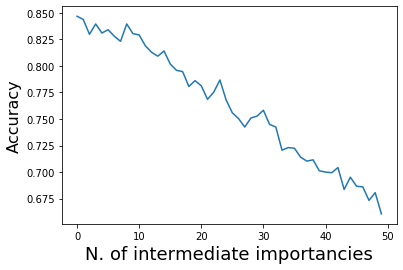

In [175]:
preturbed_perm_accuraties = examine_interpretation(xgb_model, X_test, y_test, perm_importances, epsilon=2, resolution=50, proportionality_mode=0)

## Mode 1

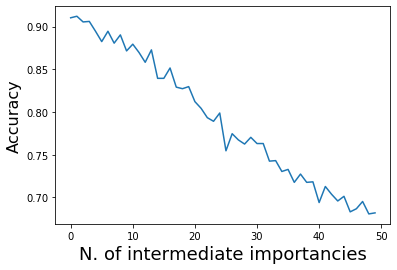

In [177]:
preturbed_perm_accuraties = examine_interpretation(xgb_model, X_test, y_test, perm_importances, epsilon=2, resolution=50, proportionality_mode=1)

# Preturbation based on shapley values

In [122]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)

In [123]:
shap_imps = []
transposed_shap = [*zip(*xgb_shap_values)]
for idx, col in enumerate(transposed_shap):
    shap_imps.append(np.mean(list(map(lambda x: abs(x), col))))

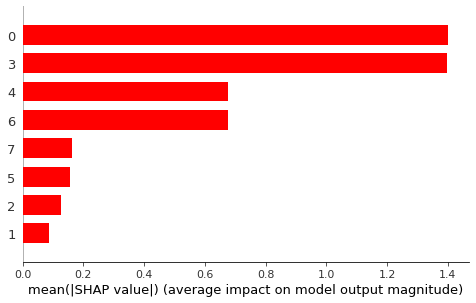

In [124]:
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar", color='red')

## Mode 0

In [ ]:
preturbed_shap_accuracies = examine_interpretation(xgb_model, X_test, y_test, shap_imps, epsilon=2, resolution=50)

## Mode 1

In [ ]:
preturbed_shap_accuracies = examine_interpretation(xgb_model, X_test, y_test, shap_imps, epsilon=2, resolution=50, proportionality_mode=1)

# Test for dataset without noise features

In [128]:
newx, newy = make_classification(n_samples=1000, n_informative=2, n_features=2, n_redundant=0)
newx = preprocessing.normalize(newx)
newx=pd.DataFrame(data=newx)

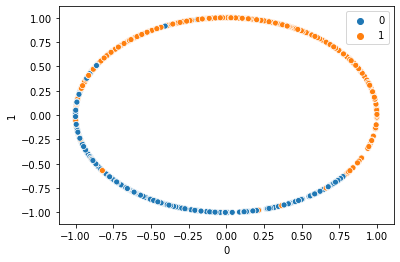

In [146]:
sns.scatterplot(x=newx[0],y=newx[1],hue=newy)

In [147]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(newx, newy, test_size=0.33, random_state=42)

In [148]:
xgb_model2 = xgb.XGBClassifier()
xgb_model2.fit(X_train2, y_train2)
xgb_preds2 = xgb_model2.predict(X_test2)
print(accuracy_score(y_test2, xgb_preds2))

print(classification_report(y_test2, xgb_preds2))

0.9
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       151
           1       0.97      0.84      0.90       179

   micro avg       0.90      0.90      0.90       330
   macro avg       0.90      0.91      0.90       330
weighted avg       0.91      0.90      0.90       330



## Permutation importances

In [149]:
perm2 = PermutationImportance(xgb_model2, random_state=1).fit(X_test2, y_test2)
perm_importances2 = perm2.feature_importances_
eli5.show_weights(perm2)

Weight,Feature
0.3376 ± 0.0363,x1
0.0952 ± 0.0205,x0


## Mode 0

[<matplotlib.lines.Line2D at 0x1c28edd6a0>]

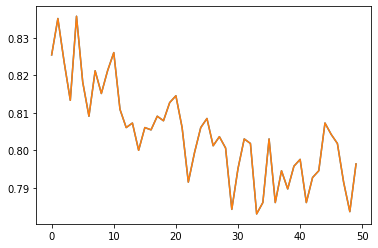

In [169]:
preturbed_perm_accuraties2 = examine_interpretation(xgb_model2, X_test2, y_test2, perm_importances2, epsilon=2, resolution=50, proportionality_mode=0)
plt.plot(preturbed_perm_accuraties2)

# Mode 1

[<matplotlib.lines.Line2D at 0x1c2adaf860>]

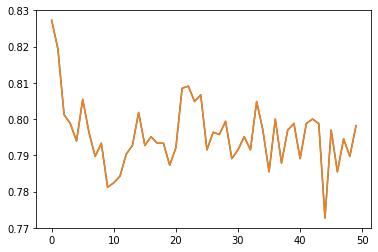

In [170]:
preturbed_perm_accuraties2 = examine_interpretation(xgb_model2, X_test2, y_test2, perm_importances2, epsilon=2, resolution=50, proportionality_mode=1)
plt.plot(preturbed_perm_accuraties2)

## Shapley values

In [153]:
xgb_explainer2 = shap.TreeExplainer(xgb_model2)
xgb_shap_values2 = xgb_explainer2.shap_values(X_test2)

In [154]:
shap_imps2 = []
transposed_shap2 = [*zip(*xgb_shap_values2)]
for idx, col in enumerate(transposed_shap2):
    shap_imps2.append(np.mean(list(map(lambda x: abs(x), col))))

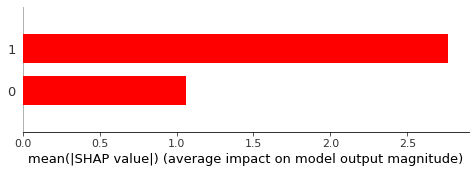

In [155]:
shap.summary_plot(xgb_shap_values2, X_test2, plot_type="bar", color='red')

## Mode 0

[<matplotlib.lines.Line2D at 0x1c2aef2dd8>]

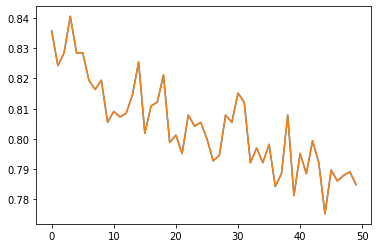

In [173]:
preturbed_shap_accuracies2 = examine_interpretation(xgb_model2, X_test2, y_test2, shap_imps2, epsilon=2, resolution=50)
plt.plot(preturbed_shap_accuracies2)

## Mode 1

[<matplotlib.lines.Line2D at 0x1c2aead128>]

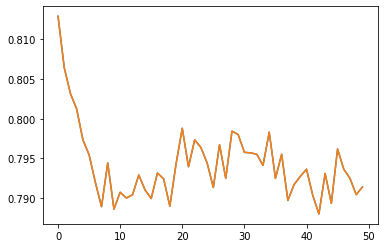

In [172]:
preturbed_shap_accuracies2 = examine_interpretation(xgb_model2, X_test2, y_test2, shap_imps2, epsilon=2, resolution=50, proportionality_mode=1, count_per_step=50)
plt.plot(preturbed_shap_accuracies2)